# Breast Cancer Survival Analysis - Black Patients

This notebook analyzes breast cancer survival data with a focus on racial disparities, particularly for Black patients.

## Setup and Import Libraries

In [10]:
# Install required packages if needed
# !pip install pandas numpy matplotlib seaborn lifelines scipy

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from scipy.stats import ttest_ind, chi2_contingency
import warnings

warnings.filterwarnings("ignore")

# Set the style for visualizations
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("deep")
sns.set_context("notebook")

## Data Loading and Exploration

In [4]:
# Load the data
file_path = "data1.csv"
df = pd.read_csv(file_path)
print(f"Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns")

Dataset loaded with 1084 rows and 63 columns


In [5]:
# Display the first few rows
df.head()

,Study ID,Patient ID,Sample ID,Diagnosis Age,Neoplasm Disease Stage American Joint Committee on Cancer Code,American Joint Committee on Cancer Publication Version Type,Aneuploidy Score,Buffa Hypoxia Score,Cancer Type,TCGA PanCanAtlas Cancer Type Acronym,...,Tumor Break Load,Tissue Prospective Collection Indicator,Tissue Retrospective Collection Indicator,Tissue Source Site,Tissue Source Site Code,TMB (nonsynonymous),Tumor Disease Anatomic Site,Tumor Type,Patient Weight,Winter Hypoxia Score
0,brca_tcga_pan_can_atlas_2018,TCGA-3C-AAAU,TCGA-3C-AAAU-01,55,STAGE X,6TH,19.0,-21.0,Breast Cancer,BRCA,...,205.0,No,Yes,Columbia University,3C,0.800000,Breast,Infiltrating Lobular Carcinoma,NaN,-28.0
1,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALI,TCGA-3C-AALI-01,50,STAGE IIB,6TH,22.0,5.0,Breast Cancer,BRCA,...,190.0,No,Yes,Columbia University,3C,15.266667,Breast,Infiltrating Ductal Carcinoma,NaN,20.0
2,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALJ,TCGA-3C-AALJ-01,62,STAGE IIB,7TH,13.0,-5.0,Breast Cancer,BRCA,...,365.0,No,Yes,Columbia University,3C,0.933333,Breast,Infiltrating Ductal Carcinoma,NaN,-10.0
3,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALK,TCGA-3C-AALK-01,52,STAGE IA,7TH,4.0,-27.0,Breast Cancer,BRCA,...,25.0,No,Yes,Columbia University,3C,1.500000,Breast,Infiltrating Ductal Carcinoma,NaN,4.0
4,brca_tcga_pan_can_atlas_2018,TCGA-4H-AAAK,TCGA-4H-AAAK-01,50,STAGE IIIA,7TH,7.0,-27.0,Breast Cancer,BRCA,...,36.0,Yes,No,"Proteogenex, Inc.",4H,0.700000,Breast,Infiltrating Lobular Carcinoma,NaN,-20.0


In [35]:
# Summary statistics
# print(df.describe())

# Check for missing values
# missing = df.isnull().sum()
# print(missing)
# print(missing[missing > 0])

In [7]:
df["Race Category"].value_counts()

Race Category
White                               751
Black or African American           182
Asian                                60
American Indian or Alaska Native      1
Name: count, dtype: int64

## Data Preparation

In [8]:
# Set the appropriate column names based on your data exploration

race_column = "Race Category"  # Replace with actual column name
time_column = "Overall Survival (Months)"  # Replace with actual column name
event_column = "Overall Survival Status"  # Replace with actual column name (1=event occurred, 0=censored)

In [9]:
# Prepare data for survival analysis
def prepare_survival_data(df, race_column, time_column, event_column):
    """Prepare data for survival analysis"""
    # Make a copy to avoid modifying the original dataframe
    survival_df = df.copy()

    # Handle missing values
    survival_df = survival_df.dropna(subset=[race_column, time_column, event_column])

    # Remove Native American patients due to small sample size
    survival_df[race_column] = survival_df[race_column].loc[
        survival_df[race_column].isin(["Black or African American", "White", "Asian"])
    ]

    # Create binary indicator for Black patients
    survival_df["is_black"] = (
        survival_df[race_column] == "Black or African American"
    ).astype(int)

    # Survival status: 1 for event occurred, 0 for censored
    survival_df["event"] = survival_df[event_column].apply(
        lambda x: 1 if x == "1:DECEASED" else 0
    )

    return survival_df


# Create the survival dataframe
survival_df = prepare_survival_data(df, race_column, time_column, event_column)
event_column = "event"
survival_df.head()

,Study ID,Patient ID,Sample ID,Diagnosis Age,Neoplasm Disease Stage American Joint Committee on Cancer Code,American Joint Committee on Cancer Publication Version Type,Aneuploidy Score,Buffa Hypoxia Score,Cancer Type,TCGA PanCanAtlas Cancer Type Acronym,...,Tissue Retrospective Collection Indicator,Tissue Source Site,Tissue Source Site Code,TMB (nonsynonymous),Tumor Disease Anatomic Site,Tumor Type,Patient Weight,Winter Hypoxia Score,is_black,event
0,brca_tcga_pan_can_atlas_2018,TCGA-3C-AAAU,TCGA-3C-AAAU-01,55,STAGE X,6TH,19.0,-21.0,Breast Cancer,BRCA,...,Yes,Columbia University,3C,0.800000,Breast,Infiltrating Lobular Carcinoma,NaN,-28.0,0,0
1,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALI,TCGA-3C-AALI-01,50,STAGE IIB,6TH,22.0,5.0,Breast Cancer,BRCA,...,Yes,Columbia University,3C,15.266667,Breast,Infiltrating Ductal Carcinoma,NaN,20.0,1,0
2,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALJ,TCGA-3C-AALJ-01,62,STAGE IIB,7TH,13.0,-5.0,Breast Cancer,BRCA,...,Yes,Columbia University,3C,0.933333,Breast,Infiltrating Ductal Carcinoma,NaN,-10.0,1,0
3,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALK,TCGA-3C-AALK-01,52,STAGE IA,7TH,4.0,-27.0,Breast Cancer,BRCA,...,Yes,Columbia University,3C,1.500000,Breast,Infiltrating Ductal Carcinoma,NaN,4.0,1,0
4,brca_tcga_pan_can_atlas_2018,TCGA-4H-AAAK,TCGA-4H-AAAK-01,50,STAGE IIIA,7TH,7.0,-27.0,Breast Cancer,BRCA,...,No,"Proteogenex, Inc.",4H,0.700000,Breast,Infiltrating Lobular Carcinoma,NaN,-20.0,0,0


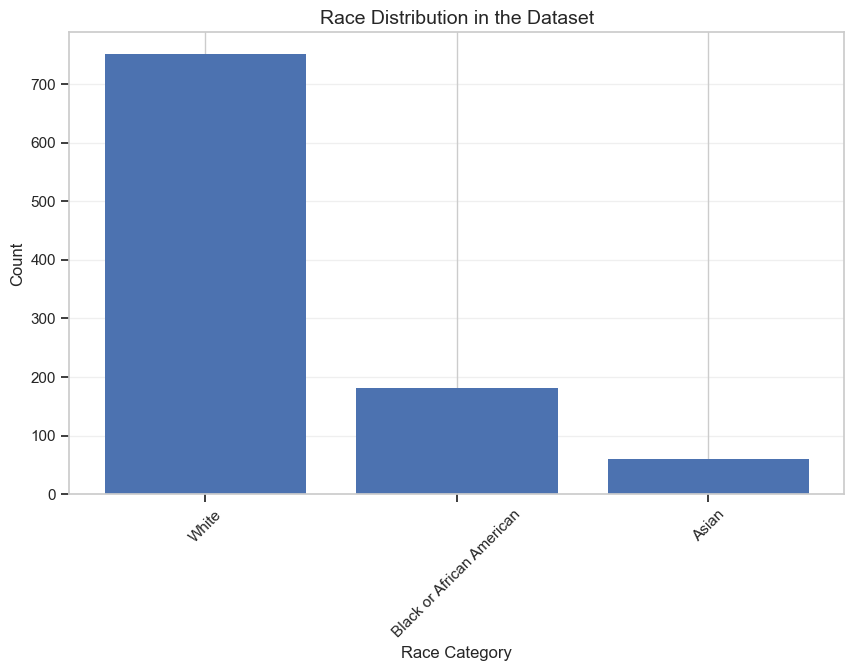

In [11]:
# Plot the race distribution
plt.figure(figsize=(10, 6))

# Drop rows with missing values in the "Race Category" column
race_counts = survival_df["Race Category"].dropna().value_counts()

# Create the bar plot
plt.bar(race_counts.index, race_counts.values)
plt.title("Race Distribution in the Dataset", fontsize=14)
plt.xlabel("Race Category", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", alpha=0.3)
plt.show()

In [12]:
# Plot the distribution of cancer stages
# Group cancer stages by number
stage_mapping = {
    "STAGE I": "Stage 1",
    "STAGE IA": "Stage 1",
    "STAGE IB": "Stage 1",
    "STAGE II": "Stage 2",
    "STAGE IIA": "Stage 2",
    "STAGE IIB": "Stage 2",
    "STAGE III": "Stage 3",
    "STAGE IIIA": "Stage 3",
    "STAGE IIIB": "Stage 3",
    "STAGE IIIC": "Stage 3",
    "STAGE IV": "Stage 4",
    "STAGE X": "Unknown",
}

# Apply the mapping to create a new column for grouped stages
survival_df["Grouped Stage"] = (
    survival_df["Neoplasm Disease Stage American Joint Committee on Cancer Code"]
    .dropna()
    .map(stage_mapping)
)

In [18]:
# Remove rows where Grouped Stage is 'Unknown'
filtered_df = survival_df[survival_df["Grouped Stage"] != "Unknown"]

print(f"Value Counts before filtering {survival_df["Grouped Stage"].value_counts()}")

print(
    f"Total count before filtering {survival_df["Grouped Stage"].value_counts().sum()}"
)
print("\n")

# Show value counts
print(filtered_df["Grouped Stage"].value_counts())

# Show total count after filtering
total = filtered_df["Grouped Stage"].value_counts().sum()
print("Total mapped stages (excluding 'Unknown'):", total)

Value Counts before filtering Grouped Stage
Stage 2    562
Stage 3    227
Stage 1    176
Stage 4     15
Unknown      9
Name: count, dtype: int64
Total count before filtering 989


Grouped Stage
Stage 2    562
Stage 3    227
Stage 1    176
Stage 4     15
Name: count, dtype: int64
Total mapped stages (excluding 'Unknown'): 980


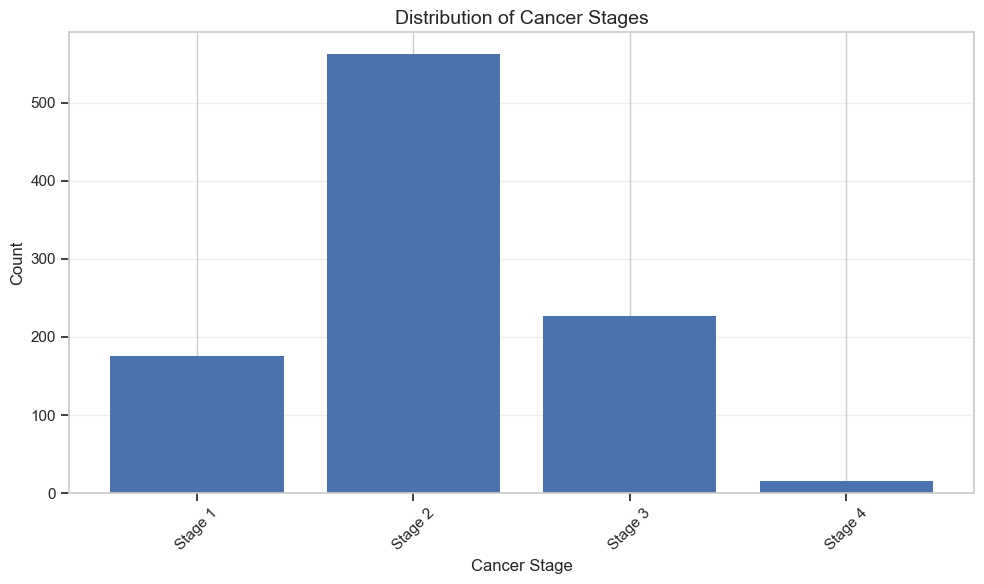

In [19]:
plt.figure(figsize=(10, 6))

# Compute value counts using the filtered DataFrame
stage_counts = filtered_df["Grouped Stage"].value_counts()

# Define the desired stage order (excluding "Unknown")
ordered_stages = ["Stage 1", "Stage 2", "Stage 3", "Stage 4"]
stage_counts = stage_counts.reindex(ordered_stages)

# Create the bar plot
plt.bar(stage_counts.index, stage_counts.values)

plt.title("Distribution of Cancer Stages", fontsize=14)
plt.xlabel("Cancer Stage", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

## Exploratory Data Visualization

Let's create some visualizations to better understand the data.

In [21]:
# Display the first few rows of the original DataFrame
display(survival_df.head())

# Print all unique race categories in the dataset
print(survival_df["Race Category"].unique())

# Filter the dataset to include only White and Black patients
df_filtered = survival_df[
    (survival_df["Race Category"] == "White")
    | (survival_df["Race Category"] == "Black or African American")
]

# Display the first few rows of the filtered DataFrame
display(df_filtered.head())

# Print unique race categories in the filtered DataFrame to verify filtering
print(df_filtered["Race Category"].unique())

,Study ID,Patient ID,Sample ID,Diagnosis Age,Neoplasm Disease Stage American Joint Committee on Cancer Code,American Joint Committee on Cancer Publication Version Type,Aneuploidy Score,Buffa Hypoxia Score,Cancer Type,TCGA PanCanAtlas Cancer Type Acronym,...,Tissue Source Site,Tissue Source Site Code,TMB (nonsynonymous),Tumor Disease Anatomic Site,Tumor Type,Patient Weight,Winter Hypoxia Score,is_black,event,Grouped Stage
0,brca_tcga_pan_can_atlas_2018,TCGA-3C-AAAU,TCGA-3C-AAAU-01,55,STAGE X,6TH,19.0,-21.0,Breast Cancer,BRCA,...,Columbia University,3C,0.800000,Breast,Infiltrating Lobular Carcinoma,NaN,-28.0,0,0,Unknown
1,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALI,TCGA-3C-AALI-01,50,STAGE IIB,6TH,22.0,5.0,Breast Cancer,BRCA,...,Columbia University,3C,15.266667,Breast,Infiltrating Ductal Carcinoma,NaN,20.0,1,0,Stage 2
2,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALJ,TCGA-3C-AALJ-01,62,STAGE IIB,7TH,13.0,-5.0,Breast Cancer,BRCA,...,Columbia University,3C,0.933333,Breast,Infiltrating Ductal Carcinoma,NaN,-10.0,1,0,Stage 2
3,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALK,TCGA-3C-AALK-01,52,STAGE IA,7TH,4.0,-27.0,Breast Cancer,BRCA,...,Columbia University,3C,1.500000,Breast,Infiltrating Ductal Carcinoma,NaN,4.0,1,0,Stage 1
4,brca_tcga_pan_can_atlas_2018,TCGA-4H-AAAK,TCGA-4H-AAAK-01,50,STAGE IIIA,7TH,7.0,-27.0,Breast Cancer,BRCA,...,"Proteogenex, Inc.",4H,0.700000,Breast,Infiltrating Lobular Carcinoma,NaN,-20.0,0,0,Stage 3


['White' 'Black or African American' 'Asian' nan]


,Study ID,Patient ID,Sample ID,Diagnosis Age,Neoplasm Disease Stage American Joint Committee on Cancer Code,American Joint Committee on Cancer Publication Version Type,Aneuploidy Score,Buffa Hypoxia Score,Cancer Type,TCGA PanCanAtlas Cancer Type Acronym,...,Tissue Source Site,Tissue Source Site Code,TMB (nonsynonymous),Tumor Disease Anatomic Site,Tumor Type,Patient Weight,Winter Hypoxia Score,is_black,event,Grouped Stage
0,brca_tcga_pan_can_atlas_2018,TCGA-3C-AAAU,TCGA-3C-AAAU-01,55,STAGE X,6TH,19.0,-21.0,Breast Cancer,BRCA,...,Columbia University,3C,0.800000,Breast,Infiltrating Lobular Carcinoma,NaN,-28.0,0,0,Unknown
1,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALI,TCGA-3C-AALI-01,50,STAGE IIB,6TH,22.0,5.0,Breast Cancer,BRCA,...,Columbia University,3C,15.266667,Breast,Infiltrating Ductal Carcinoma,NaN,20.0,1,0,Stage 2
2,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALJ,TCGA-3C-AALJ-01,62,STAGE IIB,7TH,13.0,-5.0,Breast Cancer,BRCA,...,Columbia University,3C,0.933333,Breast,Infiltrating Ductal Carcinoma,NaN,-10.0,1,0,Stage 2
3,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALK,TCGA-3C-AALK-01,52,STAGE IA,7TH,4.0,-27.0,Breast Cancer,BRCA,...,Columbia University,3C,1.500000,Breast,Infiltrating Ductal Carcinoma,NaN,4.0,1,0,Stage 1
4,brca_tcga_pan_can_atlas_2018,TCGA-4H-AAAK,TCGA-4H-AAAK-01,50,STAGE IIIA,7TH,7.0,-27.0,Breast Cancer,BRCA,...,"Proteogenex, Inc.",4H,0.700000,Breast,Infiltrating Lobular Carcinoma,NaN,-20.0,0,0,Stage 3


['White' 'Black or African American']


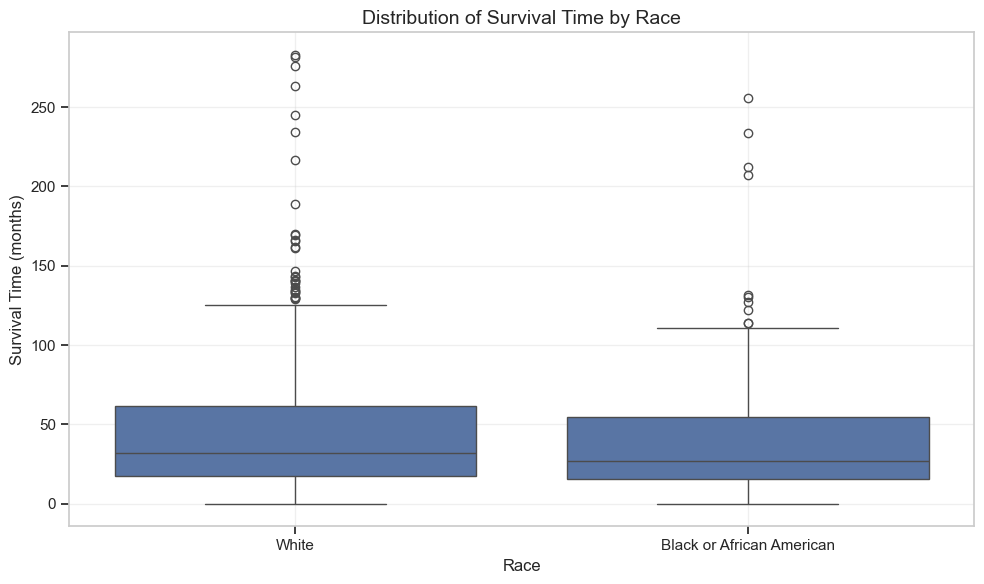

In [23]:
# Define column names (replace with actual column names from your dataset)
race_column = "Race Category"  # Column that contains race information
time_column = "Overall Survival (Months)"  # Column that contains survival time

# Optional: reorder stage labels (if plotting stage distribution separately)
ordered_stages = ["Stage 1", "Stage 2", "Stage 3", "Stage 4", "Unknown"]
stage_counts = stage_counts.reindex(ordered_stages)

# Plot distribution of survival time across race groups
plt.figure(figsize=(10, 6))
sns.boxplot(x=race_column, y=time_column, data=df_filtered)

plt.title("Distribution of Survival Time by Race", fontsize=14)
plt.xlabel("Race", fontsize=12)
plt.ylabel("Survival Time (months)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [24]:
# Calculate average survival times grouped by race
average_survival_by_race = df_filtered.groupby(race_column)[time_column].mean()

# Display the result
print(average_survival_by_race)

Race Category
Black or African American    42.015554
White                        44.282935
Name: Overall Survival (Months), dtype: float64


In [25]:
from scipy.stats import ttest_ind

# Filter survival times for Black and White patients
black_patients = survival_df[survival_df[race_column] == "Black or African American"]
white_patients = survival_df[survival_df[race_column] == "White"]

# Perform Welch’s two-sample t-test (handles unequal variances)
t_stat, p_value = ttest_ind(
    black_patients[time_column].dropna(),
    white_patients[time_column].dropna(),
    equal_var=False,
)

# Print the results
print("Two-sample t-test results:")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpret the result
if p_value < 0.05:
    print(
        "There is a statistically significant difference in average survival time between Black and White patients."
    )
else:
    print(
        "There is no statistically significant difference in average survival time between Black and White patients."
    )

Two-sample t-test results:
T-statistic: -0.6640
P-value: 0.5072
There is no statistically significant difference in average survival time between Black and White patients.


In [ ]:
# Looking at survival status
df_filtered["Overall Survival Status"].value_counts()

# Clean and recode survival status
df_filtered["Survival Status"] = df_filtered["Overall Survival Status"].apply(
    lambda x: "Living" if "LIVING" in str(x) else "Deceased"
)

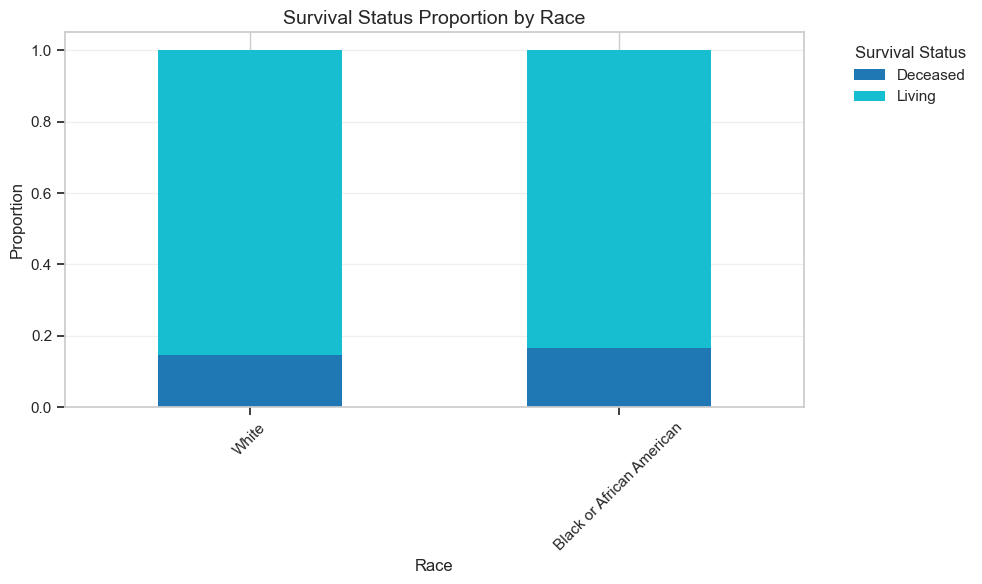

In [30]:
# Cross-tab of survival status by race (normalized to get proportions)
event_by_race = pd.crosstab(
    df_filtered[race_column], df_filtered["Survival Status"], normalize="index"
).sort_index(ascending=False)

# Plot stacked bar chart
event_by_race.plot(kind="bar", stacked=True, colormap="tab10", figsize=(10, 6))
plt.title("Survival Status Proportion by Race", fontsize=14)
plt.xlabel("Race", fontsize=12)
plt.ylabel("Proportion", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Survival Status", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

In [31]:
# Display the proportions of event rates by race
print("Proportion of event by race")
print(event_by_race)

Proportion of event by race
Survival Status            Deceased    Living
Race Category                                
White                      0.147803  0.852197
Black or African American  0.164835  0.835165


In [32]:
# Create a contingency table for survival proportions
contingency_table = pd.crosstab(survival_df["is_black"], survival_df[event_column])

# Perform the chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print the results
print("Chi-squared test results:")
print(f"Chi-squared statistic: {chi2:.4f}")
print(f"P-value: {p:.4f}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)

if p < 0.05:
    print(
        "There is a statistically significant difference in survival proportions between Black and White patients."
    )
else:
    print(
        "There is no statistically significant difference in survival proportions between Black and White patients."
    )

Chi-squared test results:
Chi-squared statistic: 0.5332
P-value: 0.4653
Degrees of freedom: 1
Expected frequencies:
[[694.36619718 117.63380282]
 [155.63380282  26.36619718]]
There is no statistically significant difference in survival proportions between Black and White patients.


## Kaplan-Meier Survival Analysis

Now we'll perform a Kaplan-Meier survival analysis to compare Black patients to others.

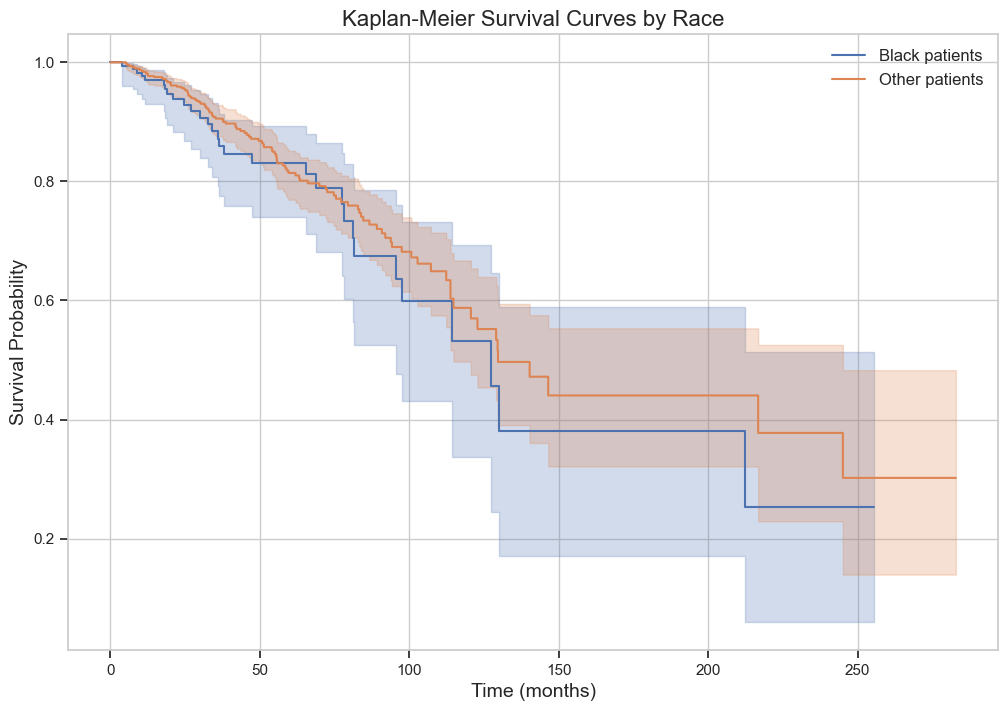


--- Log-rank Test Results ---
Test statistic: 0.9484
p-value: 0.3301
There is no statistically significant difference in survival between Black patients and others.


In [ ]:
# Uncomment and run after confirming column names

# Kaplan-Meier survival analysis


def kaplan_meier_analysis(df, time_column, event_column, group_column="is_black"):
    """Perform Kaplan-Meier survival analysis comparing Black patients to others"""
    kmf = KaplanMeierFitter()

    # Create survival plot
    plt.figure(figsize=(12, 8))

    # Plot survival curve for Black patients
    black_mask = df[group_column] == 1
    kmf.fit(
        df[black_mask][time_column],
        df[black_mask][event_column],
        label="Black patients",
    )
    ax = kmf.plot(ci_show=True)

    # Plot survival curve for other patients
    other_mask = df[group_column] == 0
    kmf.fit(
        df[other_mask][time_column],
        df[other_mask][event_column],
        label="White patients",
    )
    kmf.plot(ax=ax, ci_show=True)

    plt.title("Kaplan-Meier Survival Curves by Race", fontsize=16)
    plt.xlabel("Time (months)", fontsize=14)
    plt.ylabel("Survival Probability", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

    # Perform log-rank test to compare survival curves
    results = logrank_test(
        df[black_mask][time_column],
        df[other_mask][time_column],
        df[black_mask][event_column],
        df[other_mask][event_column],
    )

    print("\n--- Log-rank Test Results ---")
    print(f"Test statistic: {results.test_statistic:.4f}")
    print(f"p-value: {results.p_value:.4f}")
    if results.p_value < 0.05:
        print(
            "There is a statistically significant difference in survival between Black patients and others."
        )
    else:
        print(
            "There is no statistically significant difference in survival between Black patients and others."
        )

    return results


# Run the Kaplan-Meier analysis
logrank_results = kaplan_meier_analysis(survival_df, time_column, event_column)

## Cox Proportional Hazards Regression

Next, we'll perform a Cox regression to adjust for other covariates that might influence survival.

In [34]:
# Uncomment and run after confirming covariates

# Cox Proportional Hazards Regression


def cox_regression_analysis(
    df, time_column, event_column, group_column="is_black", covariates=None
):
    """Perform Cox Proportional Hazards regression analysis"""
    cph = CoxPHFitter()

    # Prepare data for Cox regression
    if covariates is None:
        # If no covariates specified, just use race
        covariates = [group_column]
    else:
        # Add race to covariates if not already included
        if group_column not in covariates:
            covariates = [group_column] + covariates

    # Fit the Cox model
    cph.fit(
        df[covariates + [time_column, event_column]],
        duration_col=time_column,
        event_col=event_column,
    )

    # Print results
    print("\n--- Cox Proportional Hazards Model Results ---")
    display(cph.summary)

    # Plot hazard ratios
    plt.figure(figsize=(12, 8))
    cph.plot()
    plt.title("Hazard Ratios with 95% Confidence Intervals", fontsize=16)
    plt.grid(True)
    plt.show()

    return cph


# Run Cox regression
cph_model = cox_regression_analysis(
    survival_df, time_column, event_column, covariates=available_covariates
)

NameError: name 'available_covariates' is not defined